<a href="https://colab.research.google.com/github/RCortez25/PhD/blob/main/LLM/4.%20Attention%20mechanism/0_Simplified_attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The importance that the model gives to a certain word is given by the attention weights.


Self-attention is the key component of modern LLMs. The "self" refers to the ability to compute attention weights by relationg different positions of the same input. Traditional attention mechanisms focus on relationships between elements in different sequences (like input and output).

The goal: Calculate a context vector $z^{(i)}$ for each input vector $x^{(i)}$. This context vector is an enriched version of each input vector which contains information about relationships of tokens.
___

In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the inpur tensors
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts   (x^3)
     [0.22, 0.58, 0.33], # with     (x^4)
     [0.77, 0.25, 0.10], # one      (x^5)
     [0.05, 0.80, 0.55]] # step     (x^6)
)

Let's plot the word into the 3-dimensional space corresponding to this example

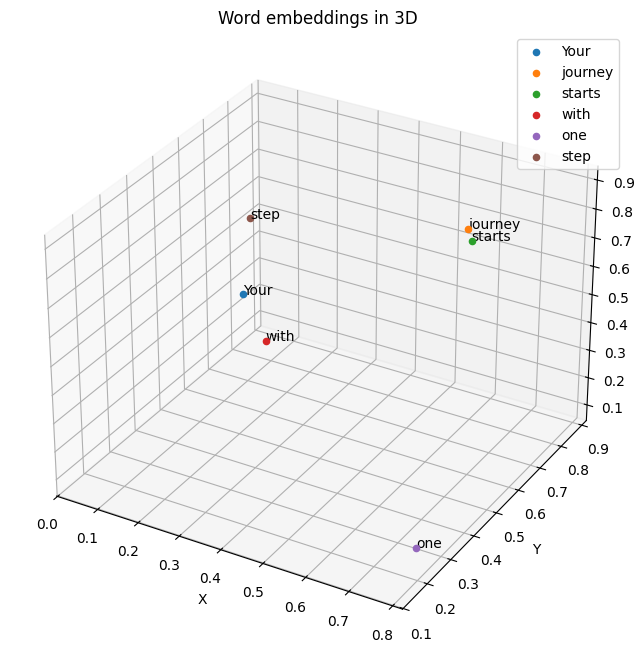

In [6]:
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Get the x, y, and z coordinates for each vector

x_coordinates = inputs[:, 0].numpy()
y_coordinates = inputs[:, 1].numpy()
z_coordinates = inputs[:, 2].numpy()

# Plot the vectors
fig = plt.figure(figsize=(10, 8)) # Increased figure size
ax = fig.add_subplot(111, projection='3d')

for x, y, z, word in zip(x_coordinates, y_coordinates, z_coordinates, words):
    ax.scatter(x, y, z, label=word)
    ax.text(x, y, z, word)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.title('Word embeddings in 3D')
plt.show()

Now, let's show the vectors

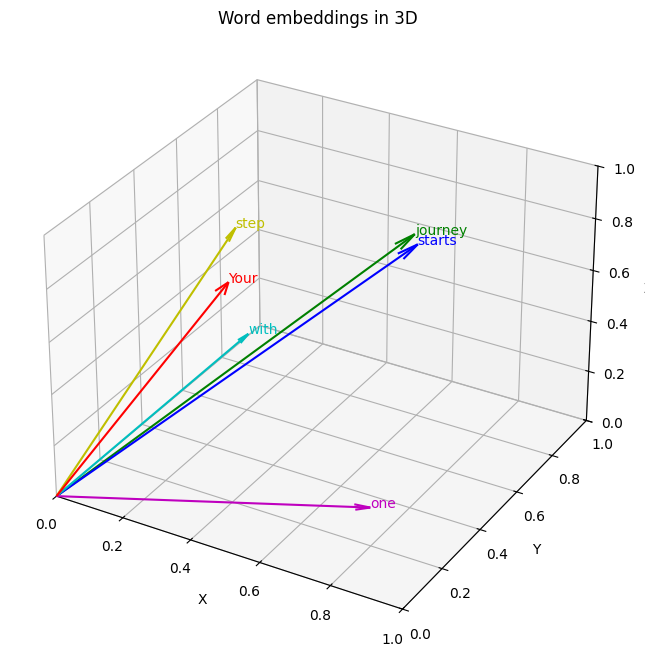

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coordinates, y_coordinates, z_coordinates, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('Word embeddings in 3D')
plt.show()